In [16]:
import numpy as np
from skimage import measure, transform
from skimage.measure import label, regionprops
from PIL import Image
import matplotlib.pyplot as plt
import glob

In [17]:
def load_image(file_path):
    image = Image.open(file_path)
    return image.convert('L')   # 그레이스케일로 변환

def find_properties(binary_particle):
    label_img = label(binary_particle)
    props = regionprops(label_img)[0]
    
    # 원본 입자의 주축과 직교하는 축의 길이를 계산
    original_axis_lengths = {
        'axis': props.major_axis_length,
        'ortho': props.minor_axis_length
    }
    
    orientation = props.orientation
    centroid = props.centroid
    bbox = props.bbox
    
    return orientation, centroid, bbox, original_axis_lengths

def add_padding(binary_particle):
    rows, cols = binary_particle.shape
    diag = int(np.sqrt(rows**2 + cols**2))
    pad_width = ((diag - rows) // 2, (diag - cols) // 2)
    padded_particle = np.pad(binary_particle, ((pad_width[0], pad_width[0]), (pad_width[1], pad_width[1])), mode='constant', constant_values=0)
    return padded_particle, pad_width

def process_particle(padded_particle, orientation, centroid, pad_width):
    # 이미지 회전
    rotation_angle = (np.pi/2 - orientation) * (180/np.pi)
    new_centroid = (centroid[0] + pad_width[0], centroid[1] + pad_width[1])
    rotated_particle = transform.rotate(padded_particle, rotation_angle, order=0, preserve_range=True, center=new_centroid)

    # 회전된 이미지에서 입자의 경계 상자를 찾아 이미지를 크롭합니다.
    label_img = label(rotated_particle > 0.5)
    props_rotated = regionprops(label_img)[0]
    minr, minc, maxr, maxc = props_rotated.bbox
    cropped_rotated_particle = rotated_particle[minr:maxr, minc:maxc]

    return cropped_rotated_particle

def adjust_particle_scale(cropped_rotated_particle, original_axis_lengths):
    # 주축과 직교축에 따라 스케일링 인자를 계산합니다.
    scale_factor_axis = original_axis_lengths['axis'] / cropped_rotated_particle.shape[1]
    scale_factor_ortho = original_axis_lengths['ortho'] / cropped_rotated_particle.shape[0]

    # 이미지를 스케일링합니다.
    scaled_particle = transform.rescale(cropped_rotated_particle, (scale_factor_ortho, scale_factor_axis), order=0, preserve_range=True, anti_aliasing=False)
    scaled_particle = (scaled_particle > 0.5).astype(int)  # 이진화

    return scaled_particle

def save_and_show_image(image_array, file_name='final_scaled_image.png'):
    # 이미지를 저장하고 화면에 보여줍니다.
    scaled_image = (1 - image_array) * 255  # 이진 이미지를 다시 그레이스케일로 변환
    image = Image.fromarray(scaled_image.astype(np.uint8))
    image.save(file_name)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

def main():
    image_files = glob.glob('*.png')

    for idx, file_path in enumerate(image_files):
        particle_image = load_image(file_path)
        particle_array = np.array(particle_image)
        binary_particle = particle_array < 128

        orientation, centroid, bbox, original_axis_lengths = find_properties(binary_particle)

        padded_particle, pad_width = add_padding(binary_particle)
        cropped_rotated_particle = process_particle(padded_particle, orientation, centroid, pad_width)

        # Call the scaling function with the original axis lengths.
        scaled_particle_image = adjust_particle_scale(cropped_rotated_particle, original_axis_lengths)

        output_file_name = f'processed_{idx}.png'
        save_and_show_image(scaled_particle_image, output_file_name)

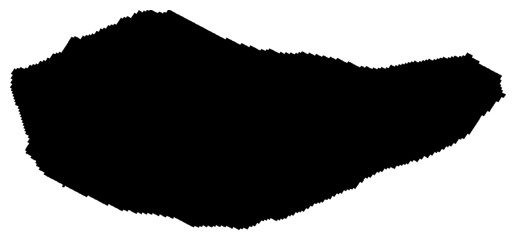

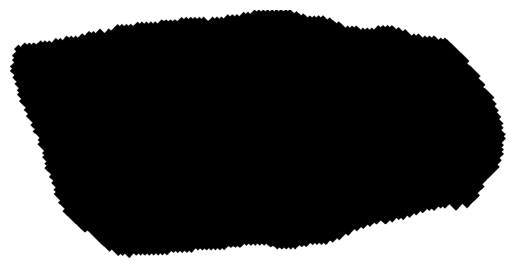

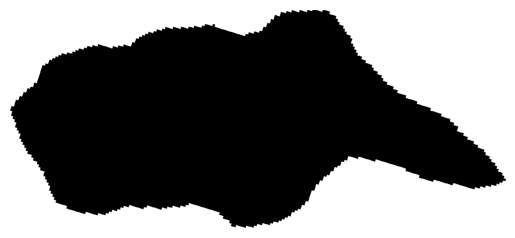

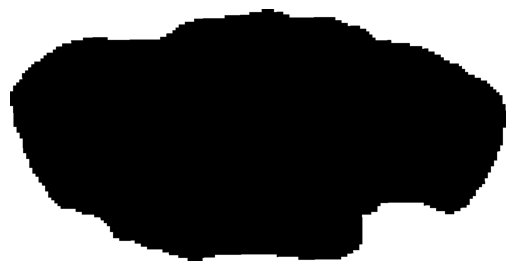

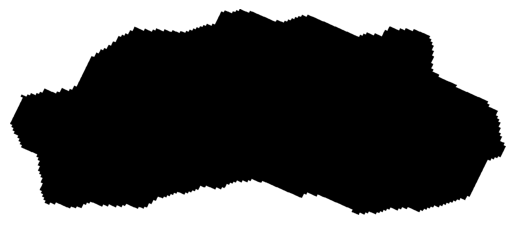

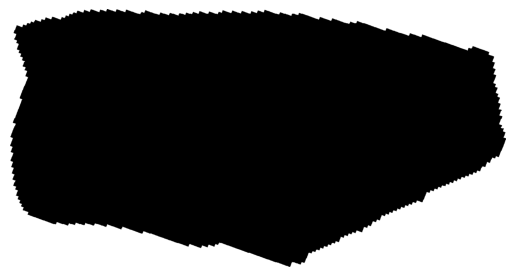

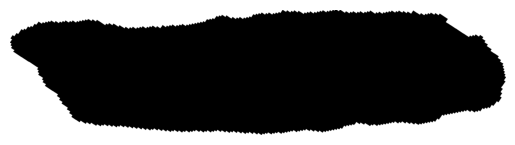

In [18]:
if __name__ == '__main__':
    main()